In [1]:
# Dec 6, 2022
# (delete some data after actions) LSTM uncomplete
# revised monitor='val_auc' => monitor='loss'

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#add
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import math
import numpy as np
from pandas import read_csv 
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.layers import LSTM 
from sklearn.preprocessing import MinMaxScaler 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score, classification_report

In [3]:
#set the size of fig
sns.set(font_scale=1.6)

##### Load and merge data

In [4]:
#df1 = pd.read_excel('case1-data-part1.xlsx')
#df2 = pd.read_excel('case1-data - part2.xlsx')
# do not use the data after ‘3/9/2021  5:09:43 PM’ 
df1 = pd.read_excel('case1-data-part1.xlsx')
df2 = pd.read_excel('case1-data - part2.xlsx')

In [5]:
# Merge two tables
data = pd.concat([df1, df2])

In [6]:
#delete [DP]
data.columns = data.columns.str.replace('[DP].', '', regex=False)
data.columns = data.columns.str.replace(' ', '_', regex=False)
data.columns = data.columns.str.replace('-', '_', regex=False)

In [7]:
#处理缺失值和重复值
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

### Sort the data by test_time


In [8]:
data.sort_values(by = ['TEST_TIME'], ascending=True, inplace=True)

In [9]:
# According to the detailed time to find the row
data[data['TEST_TIME'] == '2021-03-01 07:06:13']

,TEST_TIME,WRR(Ohm),OW2(dB)_R1,BER(dec)_R1,BER(dec)_R2,Sqz.BER(dec)_R1,Sqz.BER(dec)_R2,SSEB_EWI(nm)_R2,MRR(Ohm)_R1,TAAL(mV)_R1,...,HEAD_SN,PROJ_CODE,MARKING,UP_DN,CELL,TRACK,TESTER,RESULT,GRADE,FIXTUREID
0,2021-03-01 07:06:13,1.77796,31.61146,-2.53553,-2.44261,-1.63773,-1.54681,55.20741,468.70829,26.73804,...,0A44768D61,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R2,MG912DA


# 1. set flag

In [10]:
#add flag

row_indexer = data[(data['TEST_TIME'] >= '2021-03-01 07:06:13') & (data['TEST_TIME'] < '2021-04-01 10:37:04')].index
data.loc[row_indexer, 'flag'] = 0

row_indexer = data[(data['TEST_TIME'] >= '2021-04-01 10:37:04') & (data['TEST_TIME'] < '2021-04-12 20:50:02')].index
data.loc[row_indexer, 'flag'] = 1

row_indexer = data[(data['TEST_TIME'] >= '2021-04-12 20:50:02') & (data['TEST_TIME'] < '2021-5-12 17:53:08')].index
data.loc[row_indexer, 'flag'] = 0

row_indexer = data[(data['TEST_TIME'] >= '2021-5-12 17:53:08') & (data['TEST_TIME'] < '2021-5-13 5:34:43')].index
data.loc[row_indexer, 'flag'] = 1

row_indexer = data[(data['TEST_TIME'] >= '2021-5-13 5:34:43') & (data['TEST_TIME'] < '2021-5-18 20:35:37')].index
data.loc[row_indexer, 'flag'] = 0

row_indexer = data[(data['TEST_TIME'] >= '2021-5-18 20:35:37') & (data['TEST_TIME'] < '2021-5-19 4:40:29')].index
data.loc[row_indexer, 'flag'] = 1

row_indexer = data[(data['TEST_TIME'] >= '2021-5-19 4:40:29') & (data['TEST_TIME'] < '2021-05-28 07:41:21')].index
data.loc[row_indexer, 'flag'] = 0

row_indexer = data[(data['TEST_TIME'] >= '2021-05-28 07:41:21') & (data['TEST_TIME'] < '2021-7-3 1:53:09')].index
data.loc[row_indexer, 'flag'] = 1

row_indexer = data[(data['TEST_TIME'] >= '2021-7-3 1:53:09') & (data['TEST_TIME'] <= '2021-11-04 06:53:15')].index
data.loc[row_indexer, 'flag'] = 0

In [11]:
#update the data
data_ = data.copy(deep=True)

In [12]:
data_.head()

,TEST_TIME,WRR(Ohm),OW2(dB)_R1,BER(dec)_R1,BER(dec)_R2,Sqz.BER(dec)_R1,Sqz.BER(dec)_R2,SSEB_EWI(nm)_R2,MRR(Ohm)_R1,TAAL(mV)_R1,...,PROJ_CODE,MARKING,UP_DN,CELL,TRACK,TESTER,RESULT,GRADE,FIXTUREID,flag
0,2021-03-01 07:06:13,1.77796,31.61146,-2.53553,-2.44261,-1.63773,-1.54681,55.20741,468.70829,26.73804,...,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R2,MG912DA,0.0
1,2021-03-01 07:07:12,1.72263,33.58914,-2.57939,-2.73308,-1.28500,-1.07089,57.84807,575.25734,20.59671,...,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R2,MG912DA,0.0
2,2021-03-01 07:08:09,1.88736,30.37053,-2.51107,-2.41996,-1.47503,-1.46002,54.41332,481.94420,18.48781,...,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R2,MG912DA,0.0
3,2021-03-01 07:09:56,1.77092,32.22981,-2.66768,-2.85115,-1.35270,-1.43305,55.39537,456.35478,15.56395,...,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R2,MG912DA,0.0
4,2021-03-01 07:10:55,1.74497,28.25463,-2.34126,-2.32833,-1.81944,-1.80605,48.85652,447.53084,16.08050,...,BTSAQ0,N,0,AUTOIHSSP_DN17,102250,MG912D,PASS,R4,MG912DA,0.0


In [13]:
d1=data_[(data['TEST_TIME'] >= '2021-03-01 07:06:13') & (data['TEST_TIME'] <= '2021-04-12 17:21:19')]
d2=data_[(data['TEST_TIME'] >= '2021-04-12 20:50:02') & (data['TEST_TIME'] <= '2021-5-13 5:32:46')]
d3=data_[(data['TEST_TIME'] >= '2021-5-13 8:32:46') & (data['TEST_TIME'] < '2021-5-19 4:37:00')]
d4=data_[(data['TEST_TIME'] >= '2021-5-19 7:37:00') & (data['TEST_TIME'] < '2021-7-3 1:27:00')]
d5=data_[(data['TEST_TIME'] >= '2021-7-3 4:27:00') & (data['TEST_TIME'] < '2021-9-3 17:09:00')]

In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [15]:
def create_sequences(dd):
    # moving average
    df_move_avgdd = dd.rolling(window=5).mean()
    
    # ignore/delete not numerical data, 'UP_DN', 'TRACK', 'flag'
    df_move_avgdd.drop(['UP_DN', 'TRACK', 'flag'], axis = 1, inplace=True)

    # then add 'UP_DN', 'TRACK', 'flag'
    df_joineddd = pd.concat([df_move_avgdd, data_[['MARKING', 'UP_DN', 'flag']]], axis=1, join="inner")

    # delete first four rows and update the index
    df_joineddd.dropna(inplace=True)
    df_joineddd.reset_index(drop=True, inplace=True)

    # divide 'MARKING', 'UP_DN' to various parts 01 instead of N E or others(use numerial data to present)
    df_encodeddd = pd.get_dummies(df_joineddd, columns = ['MARKING', 'UP_DN'])

    # only select the 11 parameter data to do normlization
    df_move_avg_normalizeddd = pd.DataFrame(scaler.fit_transform(df_encodeddd[['WRR(Ohm)', 'OW2(dB)_R1', 'BER(dec)_R1', 'BER(dec)_R2',
           'Sqz.BER(dec)_R1', 'Sqz.BER(dec)_R2', 'SSEB_EWI(nm)_R2', 'MRR(Ohm)_R1',
           'TAAL(mV)_R1', 'Hw_RTD(mW)', 'Hw_RTD(nm)']]), columns=['WRR(Ohm)', 'OW2(dB)_R1', 'BER(dec)_R1', 'BER(dec)_R2',
           'Sqz.BER(dec)_R1', 'Sqz.BER(dec)_R2', 'SSEB_EWI(nm)_R2', 'MRR(Ohm)_R1',
           'TAAL(mV)_R1', 'Hw_RTD(mW)', 'Hw_RTD(nm)'])

    # add other information to the data, like repairing to the original process
    df_datadd = pd.concat([df_move_avg_normalizeddd, df_encodeddd[['flag', 
            'MARKING_N', 'UP_DN_0']]], axis=1, join="inner")


    y_dd = df_datadd['flag']
    y_dd_hi = np.array([np.mean(y_dd[i+0:i+18]) for i in range(len(y_dd)-18)])
    h_0=np.zeros(18)
    y_dd_2=np.concatenate((h_0,y_dd_hi))

    #X without flag
    y_ddh = np.array(y_dd_2)
    X_dd = df_datadd[['WRR(Ohm)', 'OW2(dB)_R1', 'BER(dec)_R1', 'BER(dec)_R2',
           'Sqz.BER(dec)_R1', 'Sqz.BER(dec)_R2', 'SSEB_EWI(nm)_R2', 'MRR(Ohm)_R1',
           'TAAL(mV)_R1', 'Hw_RTD(mW)', 'Hw_RTD(nm)', 
           'MARKING_N',  'UP_DN_0']]

    X_dd = X_dd.to_numpy()


    # reshape input to be [samples, time steps, features]
    timeStep = 100
    slice = int(X_dd.shape[0]/timeStep)
    print(X_dd.shape, slice, slice*timeStep)

    #X_dd_s = X_dd[:slice*timeStep]
    X_dd_s = X_dd[-slice*timeStep:]
    #X_dd_s = np.reshape(X_dd_s, (slice, timeStep, X.shape[1]))
    X_dd_s = np.reshape(X_dd_s, (slice, timeStep, X_dd.shape[1],1))

    y_dd_s = np.zeros(slice)
    for index1 in range(0, slice,1):
        vy_dd =y_ddh[index1*timeStep: (index1+1)*timeStep]
        #xy = np.mean(vy)
        x_ddy_dd = int(np.mean(vy_dd).round()) # updated Nov 9
        #x_ddy = np.max(vy_dd)
        y_dd_s[index1] = x_ddy_dd


    # splitting data for training, testing, val with randomization
    # Vincent Ng 
    random_state = 42
    total = len(X_dd_s)
    pos = np.count_nonzero(y_dd_s >= 0.5)
    neg = np.count_nonzero(y_dd_s < 0.5)

    X_dd_train, X_dd_test, y_dd_train, y_dd_test,idtrain,idtest = train_test_split(X_dd_s, y_dd_s, np.arange(total), test_size=0.2, random_state=random_state)
    X_dd_train, X_dd_val, y_dd_train, y_dd_val, idtrain,idval= train_test_split(X_dd_train,y_dd_train, idtrain,test_size=0.2, random_state=random_state)

    X_dd_temptrain=np.array(X_dd_train)
    X_dd_temptest=np.array(X_dd_test)
    X_dd_tempval=np.array(X_dd_val)

    return  X_dd_temptrain,X_dd_temptest,X_dd_tempval,y_dd_train,y_dd_test, y_dd_val,y_dd_2

In [16]:
X_d2_temptrain,X_d2_temptest,X_d2_tempval,y_d2_train,y_d2_test, y_d2_val,y_d2_2=create_sequences(d2)

(20300, 13) 203 20300


In [17]:
X_d3_temptrain,X_d3_temptest,X_d3_tempval,y_d3_train,y_d3_test, y_d3_val,y_d3_2=create_sequences(d3)

(4155, 13) 41 4100


In [18]:
X_d4_temptrain,X_d4_temptest,X_d4_tempval,y_d4_train,y_d4_test, y_d4_val,y_d4_2=create_sequences(d4)

(28826, 13) 288 28800


In [19]:
X_d5_temptrain,X_d5_temptest,X_d5_tempval,y_d5_train,y_d5_test, y_d5_val,y_d5_2=create_sequences(d5)

(37915, 13) 379 37900


In [20]:
#to maintain the numbers of paras
X_d1_temptrain,X_d1_temptest,X_d1_tempval,y_d1_train,y_d1_test, y_d1_val,y_d1_2=create_sequences(d1)

(25906, 13) 259 25900


# 4.Using  LSTM

In [21]:
METRICS1 = [
      keras.metrics.Accuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

2022-12-06 05:45:37.987245: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 05:45:39.444225: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-06 05:45:39.444271: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2022-12-06 05:45:39.444397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18416 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)
tf.keras.backend.clear_session()

In [24]:
look_back = 13
BATCH_SIZE = 128
EPOCHS = 200
timeStep = 100 #new add 

# create and fit the LSTM network
model = Sequential()
# OLD version - model.add(LSTM(4, input_shape=(1, look_back)))
model.add(LSTM(20, input_shape=(timeStep, look_back)))

# ADD 3 layers 
model.add(Dense(512,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='linear')) # Updated Nov 16

model.compile(loss='mean_squared_error', optimizer='adam') # Updated Nov 16
model.fit(X_d1_temptrain, y_d1_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=(X_d1_tempval, y_d1_val),verbose=2)
model.fit(X_d2_temptrain, y_d2_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=(X_d2_tempval, y_d2_val),verbose=2)
model.fit(X_d3_temptrain, y_d3_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=(X_d3_tempval, y_d3_val),verbose=2)
model.fit(X_d4_temptrain, y_d4_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=(X_d4_tempval, y_d4_val),verbose=2)
model.fit(X_d5_temptrain, y_d5_train, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping], validation_data=(X_d5_tempval, y_d5_val),verbose=2)


Epoch 1/200


2022-12-06 05:45:43.585477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500
2022-12-06 05:45:43.856442: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 - 5s - loss: 0.2841 - val_loss: 0.2794 - 5s/epoch - 2s/step
Epoch 2/200
2/2 - 0s - loss: 0.2153 - val_loss: 0.2418 - 224ms/epoch - 112ms/step
Epoch 3/200
2/2 - 0s - loss: 0.1880 - val_loss: 0.2205 - 82ms/epoch - 41ms/step
Epoch 4/200
2/2 - 0s - loss: 0.1885 - val_loss: 0.2053 - 214ms/epoch - 107ms/step
Epoch 5/200
2/2 - 0s - loss: 0.1681 - val_loss: 0.1928 - 83ms/epoch - 41ms/step
Epoch 6/200
2/2 - 0s - loss: 0.1636 - val_loss: 0.1840 - 188ms/epoch - 94ms/step
Epoch 7/200
2/2 - 0s - loss: 0.1581 - val_loss: 0.1790 - 86ms/epoch - 43ms/step
Epoch 8/200
2/2 - 0s - loss: 0.1498 - val_loss: 0.1749 - 189ms/epoch - 94ms/step
Epoch 9/200
2/2 - 0s - loss: 0.1332 - val_loss: 0.1711 - 137ms/epoch - 69ms/step
Epoch 10/200
2/2 - 0s - loss: 0.1364 - val_loss: 0.1669 - 110ms/epoch - 55ms/step
Epoch 11/200
2/2 - 0s - loss: 0.1280 - val_loss: 0.1630 - 190ms/epoch - 95ms/step
Epoch 12/200
2/2 - 0s - loss: 0.1317 - val_loss: 0.1600 - 81ms/epoch - 41ms/step
Epoch 13/200
2/2 - 0s - loss: 0.1128 - val_l

In [25]:
# Testing prediction 進行預測 Vincent
#def create_prediction(X_dd_temptest,X_dd_temptrain):
#def create_prediction(y_test, X_dd_temptest,X_dd_temptrain):
#    testPredict_dd= model.predict(X_dd_temptest)
#    trainPredict_dd= model.predict(X_dd_temptrain)
    
#    print("MSE: ",mean_squared_error(y_test, testPredict_dd))
    #return  testPredict_dd,trainPredict_dd
 #   return


# Testing prediction 進行預測 my 1

def create_prediction(X_dd_temptest,X_dd_temptrain):
    testPredict_dd= model.predict(X_dd_temptest)
    trainPredict_dd= model.predict(X_dd_temptrain)

    return  testPredict_dd,trainPredict_dd

In [26]:
# my 2
#input/output must be same as the function
testPredict_d1,trainPredict_d1=create_prediction(X_d1_temptest,X_d1_temptrain)
testPredict_d2,trainPredict_d2=create_prediction(X_d2_temptest,X_d2_temptrain)
testPredict_d3,trainPredict_d3=create_prediction(X_d3_temptest,X_d3_temptrain)
testPredict_d4,trainPredict_d4=create_prediction(X_d4_temptest,X_d4_temptrain)
testPredict_d5,trainPredict_d5=create_prediction(X_d5_temptest,X_d5_temptrain)

8/8 [==============================] - 0s 2ms/step


In [27]:
#my 3
#first is true value, second is predicted value
print("MSE_d1: ",mean_squared_error(y_d1_test, testPredict_d1))
print("MSE_d2: ",mean_squared_error(y_d2_test, testPredict_d2))
print("MSE_d3: ",mean_squared_error(y_d3_test, testPredict_d3))
print("MSE_d4: ",mean_squared_error(y_d4_test, testPredict_d4))
print("MSE_d5: ",mean_squared_error(y_d5_test, testPredict_d5))

MSE_d1:  0.1686867024243446
MSE_d2:  0.03390290941735788
MSE_d3:  0.18655131468671754
MSE_d4:  0.6166479021135391
MSE_d5:  0.018151840727150977


In [28]:
#input/output must be same as the function
#Vincent

def create_prediction(y_test, X_dd_temptest,X_dd_temptrain):
    testPredict_dd= model.predict(X_dd_temptest)
    trainPredict_dd= model.predict(X_dd_temptrain)
    
    print("MSE: ",mean_squared_error(y_test, testPredict_dd))
    #return  testPredict_dd,trainPredict_dd
    return


create_prediction(y_d1_test,X_d1_temptest,X_d1_temptrain)
create_prediction(y_d2_test,X_d2_temptest,X_d2_temptrain)
create_prediction(y_d3_test,X_d3_temptest,X_d3_temptrain)
create_prediction(y_d4_test,X_d4_temptest,X_d4_temptrain)
create_prediction(y_d5_test,X_d5_temptest,X_d5_temptrain)

6/6 [==============================] - 0s 2ms/step
MSE:  0.1686867024243446
5/5 [==============================] - 0s 2ms/step
MSE:  0.03390290941735788
1/1 [==============================] - 0s 42ms/step
MSE:  0.18655131468671754
6/6 [==============================] - 0s 2ms/step
MSE:  0.6166479021135391
8/8 [==============================] - 0s 2ms/step
MSE:  0.018151840727150977


In [29]:
# previous results
#MSE_d1:  0.18594877444178384
#MSE_d2:  0.024791341870144618
#MSE_d3:  0.21939450674598526
#MSE_d4:  0.7874931449849256
#MSE_d5:  0.0003015014115589215

In [30]:

d4.reset_index(drop=True, inplace=True)

d4['TT'] = ""
for index1 in range(0, d4.shape[0],1):
    t1 = pd.to_datetime(d4['TEST_TIME'][index1],dayfirst=True)
    d4['TT'][index1] = t1

/tmp/ipykernel_1891071/1433985162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4['TT'] = ""
/tmp/ipykernel_1891071/1433985162.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4['TT'][index1] = t1


In [31]:
str1 = 'WRR(Ohm)'
str2 = 'OW2(dB)_R1'
attr1 = ['TT',str1]
attr2 = ['TT',str1, str2]
attr3 = ['TT',str1, str2, 'BER(dec)_R1']
attr4 = ['TT',str1, str2, 'BER(dec)_R1', 'Sqz.BER(dec)_R1']
X1 = d4[attr1]
X1.set_index('TT', inplace=True)

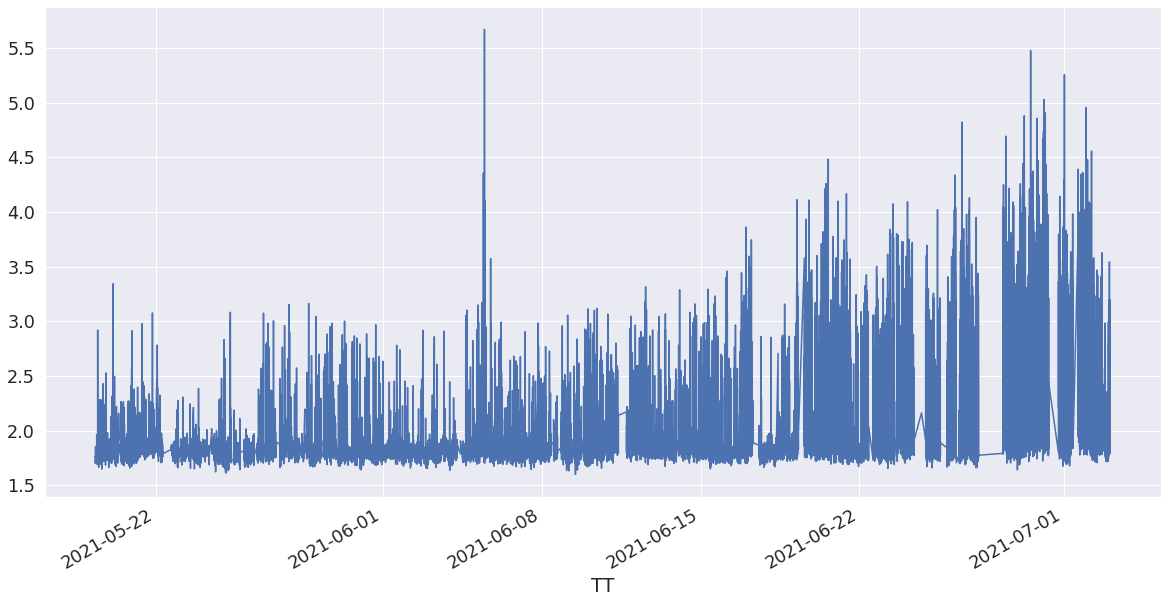

In [32]:
## Visualize the data

fig, ax = plt.subplots(figsize=(20, 10))
X1.plot(legend=False, ax=ax)
plt.show()

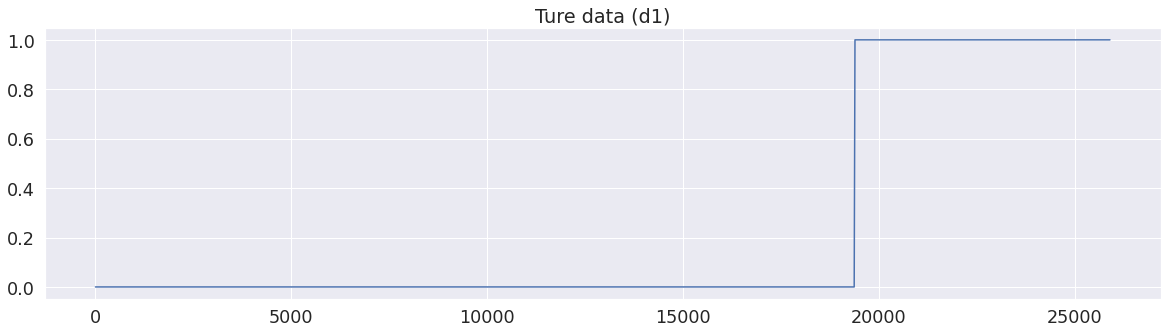

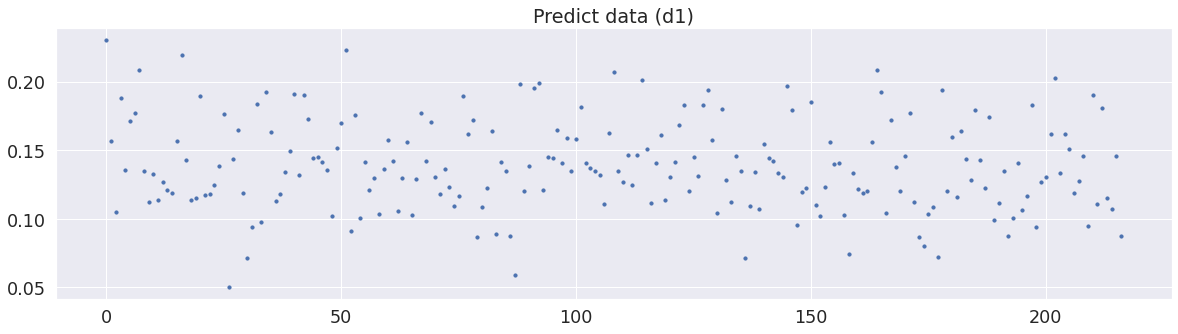

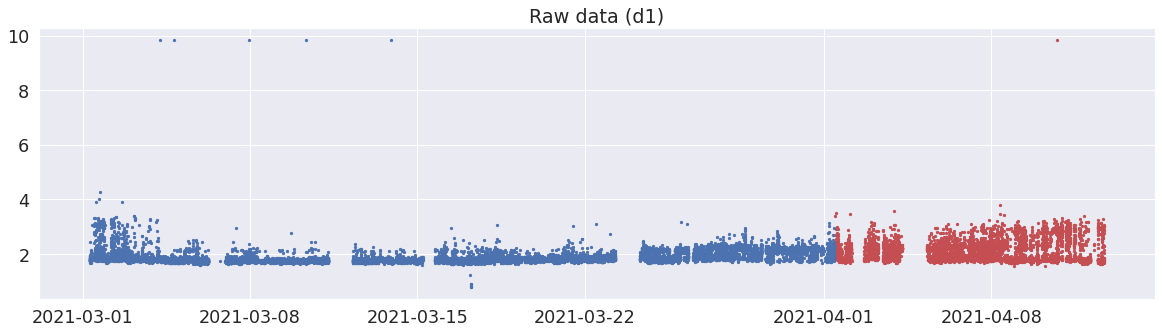

In [33]:

plt.figure(figsize=(20,5))
plt.title('Ture data (d1)')
plt.plot(y_d1_2)

x_d1_new=np.concatenate((trainPredict_d1, testPredict_d1))
plt.figure(figsize=(20,5))
plt.title('Predict data (d1)')
x_d1_aixs=range(0,len(x_d1_new))
plt.scatter(x_d1_aixs,x_d1_new,alpha = 1, s=10)


plt.figure(figsize=(20,5))
plt.title('Raw data (d1)')
d1_d1 = d1[d1['flag'] == 1]['TEST_TIME'], d1[d1['flag'] == 1]['WRR(Ohm)']
plt.scatter(d1_d1[0], d1_d1[1], s=5,color='r', label='Abnormal')
d2_d1 = d1[d1['flag'] == 0]['TEST_TIME'], d1[d1['flag'] == 0]['WRR(Ohm)']
plt.scatter(d2_d1[0], d2_d1[1], s=5, color='b', label='Abnormal')


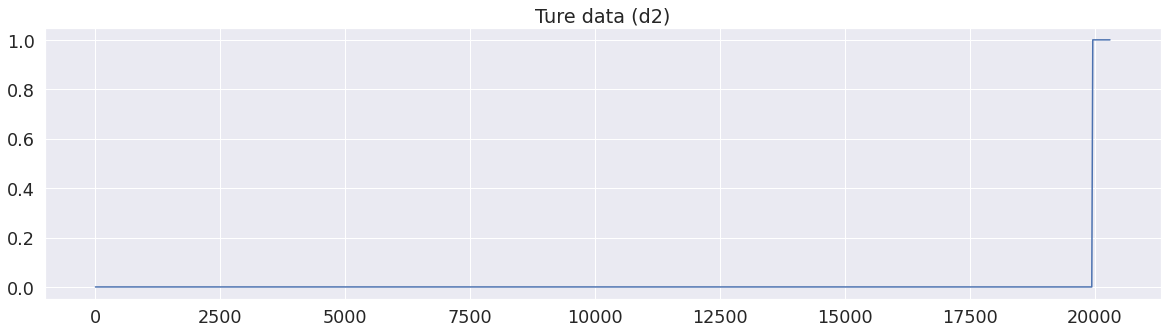

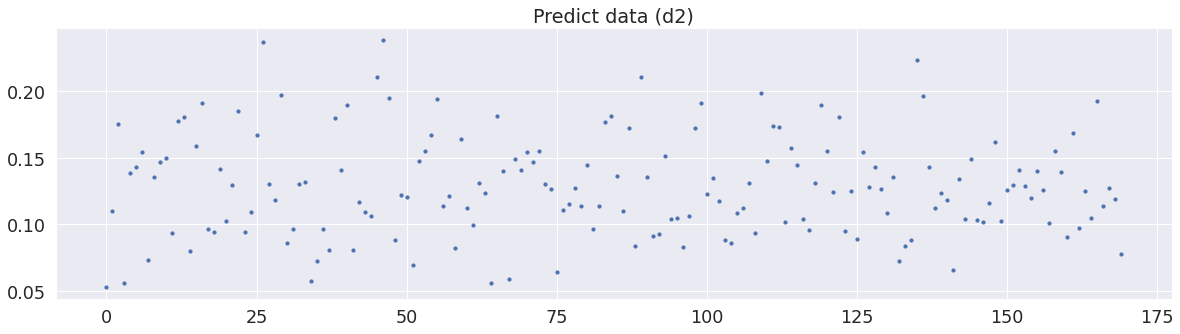

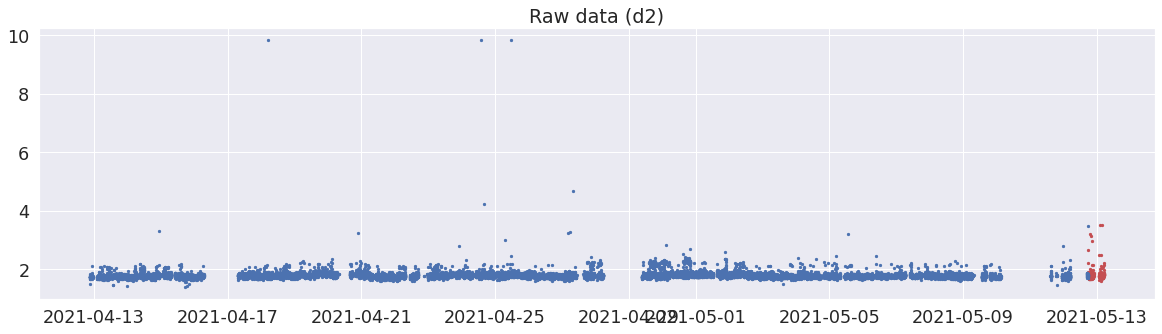

In [34]:
plt.figure(figsize=(20,5))
plt.title('Ture data (d2)')
plt.plot(y_d2_2)

x_d2_new=np.concatenate((trainPredict_d2, testPredict_d2))
plt.figure(figsize=(20,5))
plt.title('Predict data (d2)')
x_d2_aixs=range(0,len(x_d2_new))
plt.scatter(x_d2_aixs,x_d2_new,alpha = 1, s=10)


plt.figure(figsize=(20,5))
plt.title('Raw data (d2)')
d1_d2 = d2[d2['flag'] == 1]['TEST_TIME'], d2[d2['flag'] == 1]['WRR(Ohm)']
plt.scatter(d1_d2[0], d1_d2[1], s=5,color='r', label='Abnormal')
d2_d2 = d2[d2['flag'] == 0]['TEST_TIME'], d2[d2['flag'] == 0]['WRR(Ohm)']
plt.scatter(d2_d2[0], d2_d2[1], s=5, color='b', label='Abnormal')

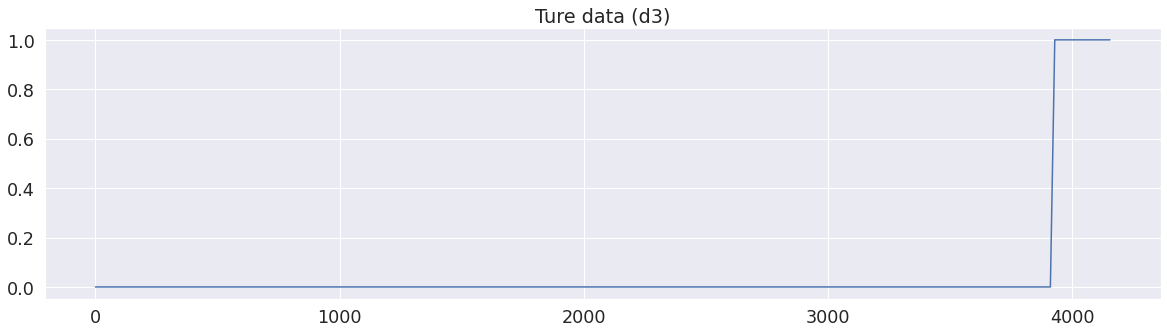

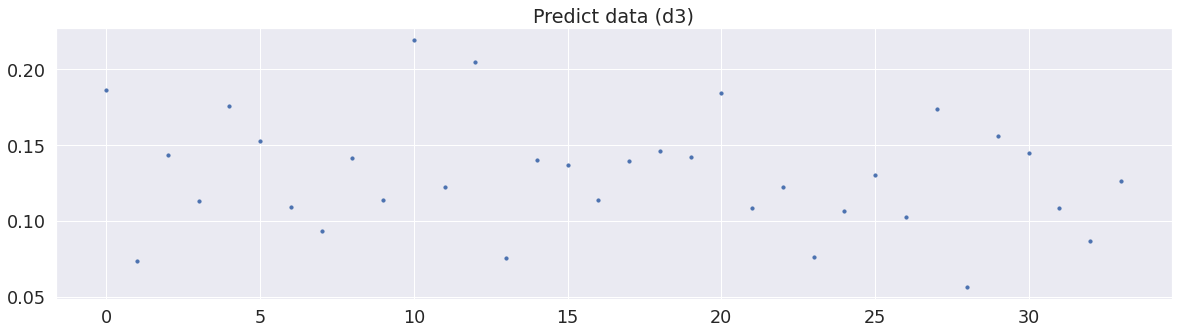

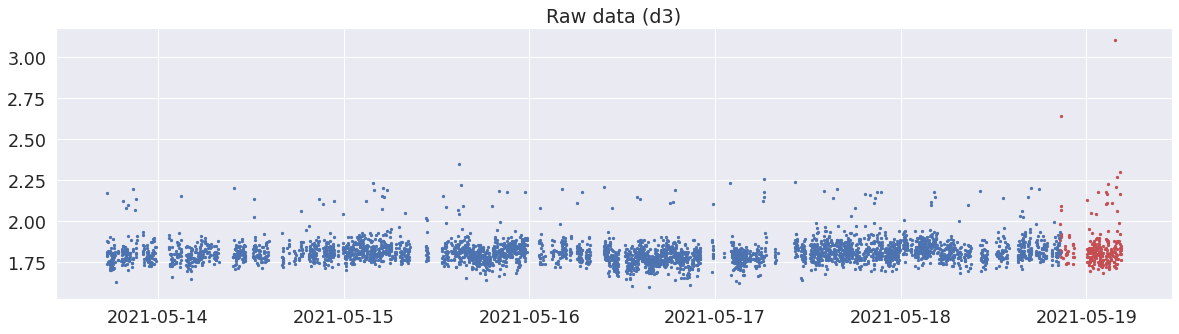

In [35]:
plt.figure(figsize=(20,5))
plt.title('Ture data (d3)')
plt.plot(y_d3_2)

x_d3_new=np.concatenate((trainPredict_d3, testPredict_d3))
plt.figure(figsize=(20,5))
plt.title('Predict data (d3)')
x_d3_aixs=range(0,len(x_d3_new))
plt.scatter(x_d3_aixs,x_d3_new,alpha = 1, s=10)


plt.figure(figsize=(20,5))
plt.title('Raw data (d3)')
d1_d3 = d3[d3['flag'] == 1]['TEST_TIME'], d3[d3['flag'] == 1]['WRR(Ohm)']
plt.scatter(d1_d3[0], d1_d3[1], s=5,color='r', label='Abnormal')
d2_d3 = d3[d3['flag'] == 0]['TEST_TIME'], d3[d3['flag'] == 0]['WRR(Ohm)']
plt.scatter(d2_d3[0], d2_d3[1], s=5, color='b', label='Abnormal')

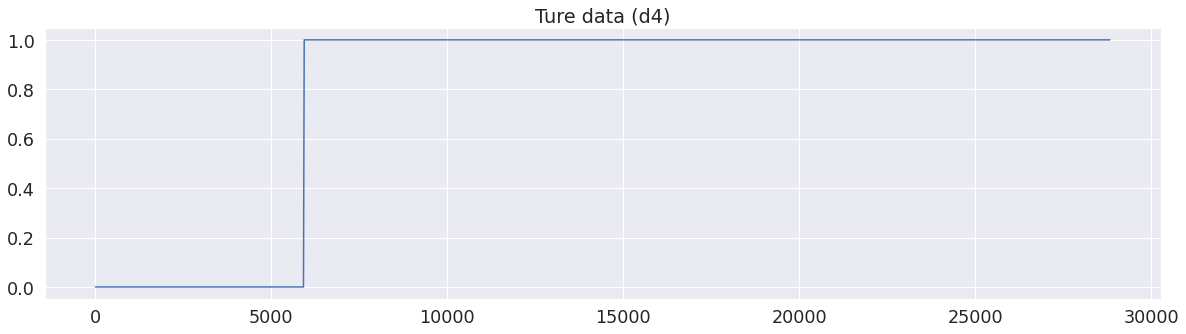

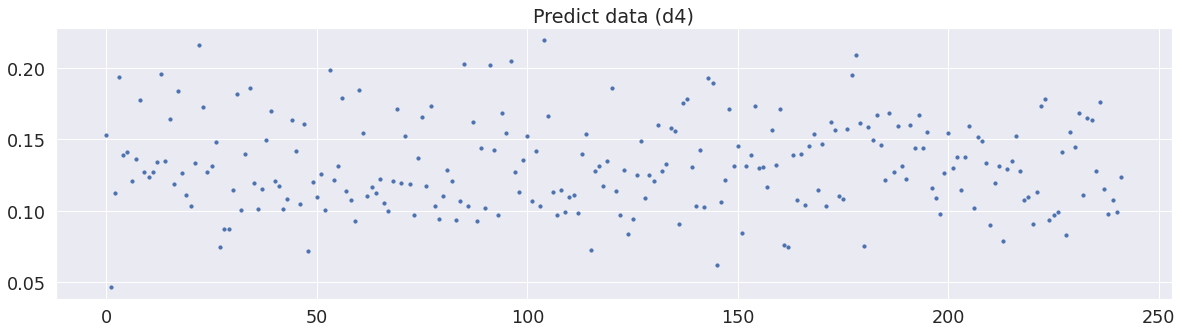

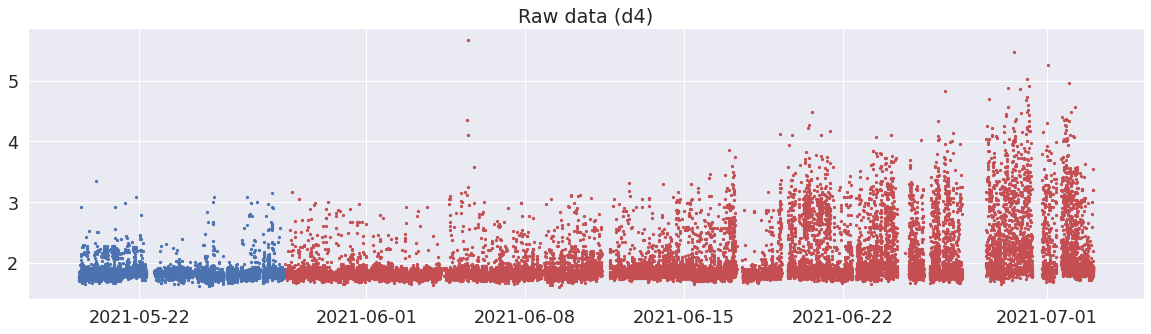

In [36]:
plt.figure(figsize=(20,5))
plt.title('Ture data (d4)')
plt.plot(y_d4_2)

x_d4_new=np.concatenate((trainPredict_d4, testPredict_d4))
plt.figure(figsize=(20,5))
plt.title('Predict data (d4)')
x_d4_aixs=range(0,len(x_d4_new))
plt.scatter(x_d4_aixs,x_d4_new,alpha = 1, s=10)


plt.figure(figsize=(20,5))
plt.title('Raw data (d4)')
d1_d4 = d4[d4['flag'] == 1]['TEST_TIME'], d4[d4['flag'] == 1]['WRR(Ohm)']
plt.scatter(d1_d4[0], d1_d4[1], s=5,color='r', label='Abnormal')
d2_d4 = d4[d4['flag'] == 0]['TEST_TIME'], d4[d4['flag'] == 0]['WRR(Ohm)']
plt.scatter(d2_d4[0], d2_d4[1], s=5, color='b', label='Abnormal')


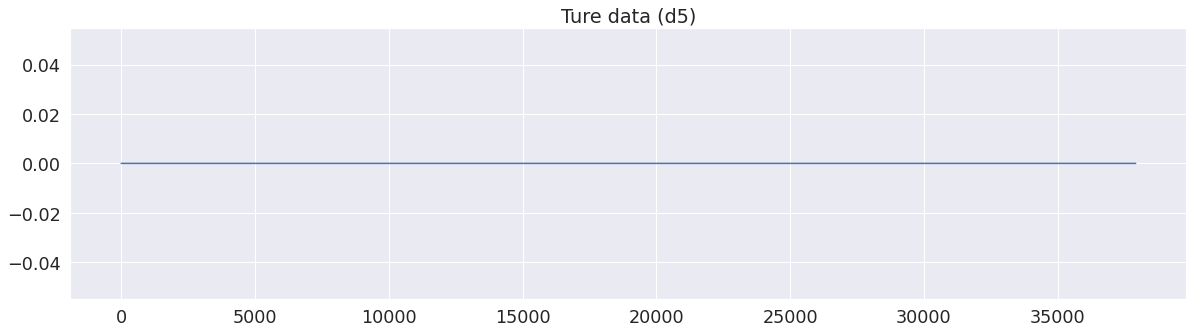

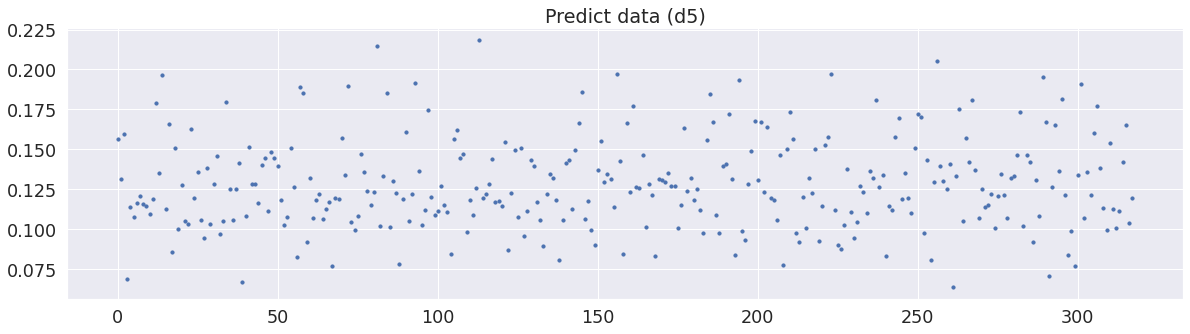

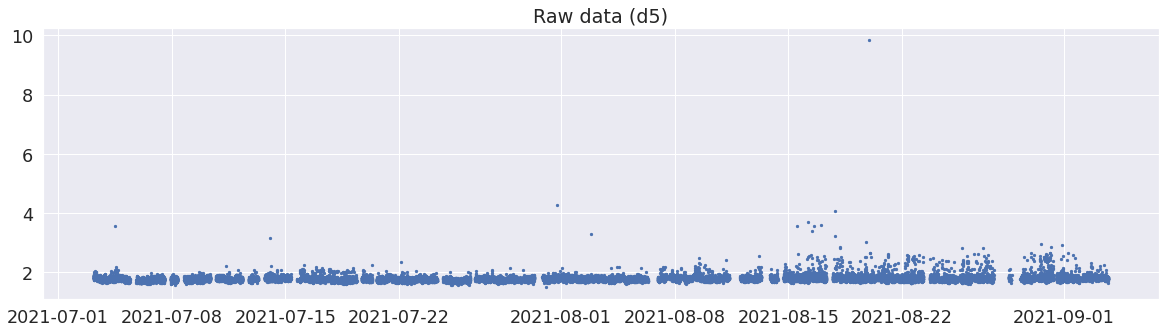

In [37]:
plt.figure(figsize=(20,5))
plt.title('Ture data (d5)')
plt.plot(y_d5_2)

x_d5_new=np.concatenate((trainPredict_d5, testPredict_d5))
plt.figure(figsize=(20,5))
plt.title('Predict data (d5)')
x_d5_aixs=range(0,len(x_d5_new))
plt.scatter(x_d5_aixs,x_d5_new,alpha = 1, s=10)


plt.figure(figsize=(20,5))
plt.title('Raw data (d5)')
d1_d5 = d5[d5['flag'] == 1]['TEST_TIME'], d5[d5['flag'] == 1]['WRR(Ohm)']
plt.scatter(d1_d5[0], d1_d5[1], s=5,color='r', label='Abnormal')
d2_d5 = d5[d5['flag'] == 0]['TEST_TIME'], d5[d5['flag'] == 0]['WRR(Ohm)']
plt.scatter(d2_d5[0], d2_d5[1], s=5, color='b', label='Abnormal')
